In [0]:
# imports dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import math

In [0]:
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])

### Original Code: Replaces all nan values in the dataset with linear interpolation values, necessary for LSTM

In [0]:
for num in range(data.shape[1]):
    data.iloc[:,num] = data.iloc[:,num].interpolate(method='linear')
    print(sum(np.isnan(x) for x in data.iloc[:,num]))

0
0
0
0
0
0
0


### I believe the following function (series_to_supervised) does not need to be modified from the source code obtained from the cited blog as it is a common ML practice to create dataframes using lagged variables


In [0]:
from pandas import DataFrame, concat

# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning (creating input data using data from previous timestamps and output data from future timestamps)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Significant Original Idea: Instead of first normalizing using MinMax Scaler as done on the blog article, I chose to first create the reframed dataframe AND apply the output layer dropouts before normalizing
### The benefit is that when it comes time to INVERSE NORMALIZE the predicted results of the model, it expects a dataframe with 796 columns instead of 1372, which is much more complicated compared to my approach because dropped output data would have to be recovered via concatenation before inversing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# frame as supervised learning (use 100 previous rows as input and predict 96 future rows)
reframed = series_to_supervised(data.values, 100, 96)

### Original Code
# drop columns we don't want to predict (drop all output values except for the 96 USAGE_KWH values)
no_pred = []
for out in range(96):
    for var in range(6):
        no_pred.append(701+var+out*7)
reframed.drop(reframed.columns[no_pred], axis=1, inplace=True)

# normalize features
# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

In [0]:
# Modified Code from the blog
# split into train and test sets (test on last 196 rows)
values = scaled
n_train_hours = len(values)-96-100
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

### I chose not to modify the following code because it is common ML practice to split train and test datasets like this; no modification is needed


In [0]:
# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# train_X values are all train rows, and all column values until the last 96, which are the 96 predicted USAGE_KWH values. 
# train_y contains all rows, and last 96 columns
# test_X contains all rows and all but last 96 columns.
# test_y contains all rows, and last 96 columns

train_X, train_y = train[:, :-96], train[:, -96:]
test_X, test_y = test[:, :-96], test[:, -96:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34744, 1, 700) (34744, 96) (196, 1, 700) (196, 96)


### Original Model Design 1: I incorporated a dropout layer after the input because I realized the blog model's design would lead to overfitting

### Original Model Design 2: I used a callback feature called ModelCheckpoint to save the modified weights at the lowest val_loss value

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
# modelcheckpoint is a way to save the lowest validation loss value during training

checkpoint = ModelCheckpoint('LSTM_100lag.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# design network
model = Sequential()
model.add(LSTM(700, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(96))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=int(train.shape[0]/96), validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[checkpoint])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 34744 samples, validate on 196 samples
Epoch 1/50
34744/34744 [==============================] - 6s 174us/step - loss: 0.0127 - val_loss: 0.0085

Epoch 00001: val_loss improved from inf to 0.00853, saving model to LSTM_100lag.h5
Epoch 2/50
34744/34744 [==============================] - 2s 58us/step - loss: 0.0090 - val_loss: 0.0089

Epoch 00002: val_loss did not improve from 0.00853
Epoch 3/50
34744/34744 [==============================] - 2s 59us/step - loss: 0.0080 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.00853 to 0.00806, saving model to LSTM_100lag.h5
Epoch 4/50
34744/34744 [==============================] - 2s 59us/step - loss: 0.0074 - val_loss: 0.0078

Epoch 00004: val_loss improved from 0.00806 to 0.00781, saving model to

### I chose to not modify this code because it is standard in the ML community to do compare training loss and testing loss; no additional modification is required


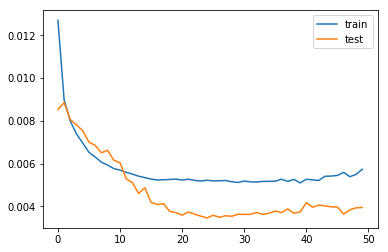

In [0]:
# code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Original Idea: Use mean squared error because it penalizes high-residual predictions more than root mean squared error


In [0]:
# load the optimum model and evaluate performance using MSE
# Code inspired by https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# Modified by Derek 

from numpy import concatenate
from sklearn.metrics import mean_squared_error
from keras.models import load_model

model = load_model('LSTM_100lag.h5')

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,-700:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:96]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 96))
inv_y = concatenate((test_y, test_X[:, -700:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:96]
# calculate MSE

mse = mean_squared_error(inv_y, inv_yhat)

print('Test MSE: %.3f' % mse)

Test MSE: 9.106


### Original Idea: Sampling 3 out of the 196 test rows to visualize the similarity of the model's predictions to ground truth

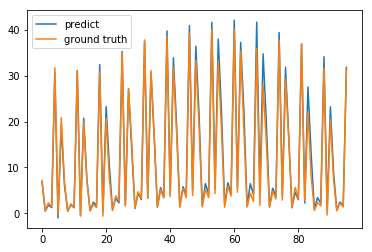

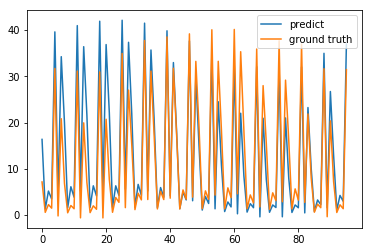

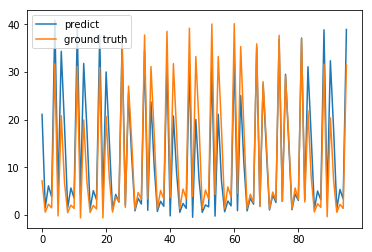

In [0]:
# Original Code
# plotting 3 randomly selected rows (of 196) from test dataset to visualize predictions versus ground truth.

pyplot.figure()
pyplot.plot(inv_yhat[0,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[30,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[60,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()